# Escalamiento multidimensional

    - Es una técnica estadística que reduce la dimensionalidad de un conjunto de datos manteniendo la 
    estructura  relativa entre los elementos. Los datos se proyectan en un espacio de menor dimensión, lo que 
    facilita su visualización y análisis. Esta técnica es útil para explorar y comprender conjuntos de datos 
    complejos, revelando patrones y relaciones que pueden no ser evidentes en el espacio original de alta 
    dimensionalidad.
    
    - Principalmente, se utiliza para dos propósitos clave:
    
        Reducción de dimensionalidad: Uno de los principales usos del escalamiento multidimensional es reducir 
        la complejidad de conjuntos de datos de alta dimensionalidad. En muchos casos, los conjuntos de datos 
        contienen una gran cantidad de variables, lo que dificulta su análisis y comprensión. Al proyectar 
        estos datos en un espacio de menor dimensión mientras se preserva la estructura y la información 
        relevante, el escalamiento multidimensional permite simplificar el análisis sin perder demasiada 
        información crucial.

        Visualización de datos: Otra aplicación importante es la visualización de datos. El escalamiento 
        multidimensional ayuda a representar datos complejos en gráficos de dispersión de baja dimensión, lo 
        que facilita la interpretación visual. Esta visualización puede revelar patrones, relaciones y 
        agrupaciones en los datos que no son evidentes en el espacio original de alta dimensionalidad. Esto es 
        especialmente útil en áreas como la exploración de datos, la minería de datos y la inteligencia 
        artificial, donde comprender la estructura subyacente de los datos es fundamental para la toma de 
        decisiones informadas.

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
import scipy.spatial.distance as distance
from sklearn.metrics.pairwise import manhattan_distances

### 1] Cargar datos

    - Se utiliza el data set de los primeros 151 pokemones y sus estadísticas dentro del juego

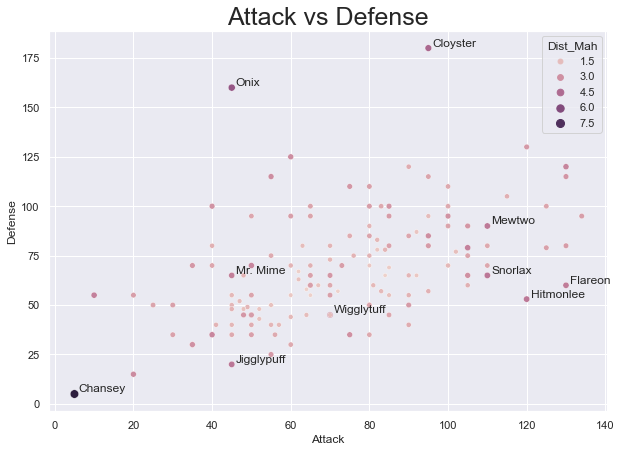

In [2]:
# Read data
main_folder = os.getcwd()
df_data = pd.read_csv(main_folder + "/Data/Pokemon.csv", index_col=0)
df_data.index.name = "#"
df_data.rename(columns={"Sp. Atk": "Sp. Attack", "Sp. Def": "Sp. Defense"}, inplace=True)

# Select first generation pokemons
df_data = df_data[~df_data["Name"].str.contains("Mega", regex=False)]
df_data = df_data[df_data["Generation"]==1].copy()

# Define cuantiative columns
features = ["HP", "Attack", "Defense", "Sp. Attack", "Sp. Defense", "Speed"]

# Compute Mahalanobus distance
centroid = np.array(df_data[features].mean(0))
centered = np.array(df_data[features] - centroid)
S = np.cov(df_data[features],rowvar=False)
S_inv = np.linalg.inv(S)
df_data["Dist_Mah"] = np.diag(centered @ (S_inv@centered.T))**0.5

# Plot Attack and Defense scatterplot coloured by Type 1
sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(10,7)})
ax = sns.scatterplot(data=df_data, x="Attack", y="Defense", hue="Dist_Mah", size="Dist_Mah")
ax.axes.set_title("Attack vs Defense",fontsize=25)
for index, row in df_data.sort_values(by=["Dist_Mah"]).tail(10).iterrows():
    ax.text(row["Attack"]+1, row["Defense"]+1, row["Name"])

### 2] Correlación de los datos
    - El set de datos es, especialmente, poco correlacionado, por lo que se espera que los procesos de reducción de dimensionalidad no sean tan efectivos. Sin emabrgo, con el proceso de MDS es posible que los datos se visualicen de manera satisfactoria y útil.

Text(0.5, 1.0, 'Corr MX')

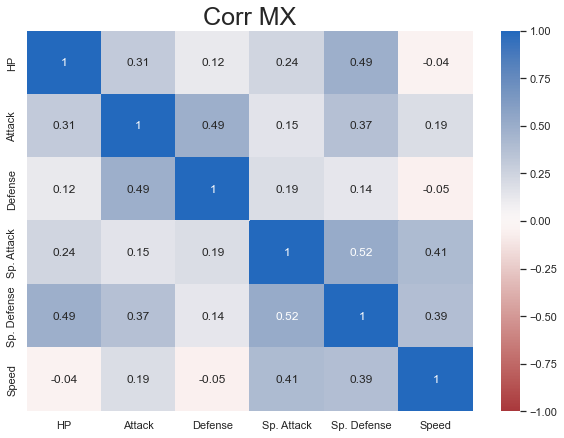

In [49]:
# Plot correlation matrix
matrix = df_data[features].corr().round(2)
ax = sns.heatmap(matrix, annot=True, vmax=1, vmin=-1, cmap="vlag_r")
ax.axes.set_title("Corr MX",fontsize=25)

### 3] Escalamiento multidimensional métrico (metric MDS)
    
    - Asume que las distancias entre elementos son significativas; pueden ser comparadas matemáticamente.
    
    - Su objetivo es encontrar una configuración de los elementos en un espacio dimensional menor (típicamente 2 o 3), tal que las distancias dos-a-dos entre los puntos se aproximen a las dadas inicialmente. Se utilizan técnicas de optimización , como mínimos cuadrados, para lograr el objetivo.
    
    - El resultado del MDS métrico es una representación de los datos en un espacio de menor dimensionalidad que preserve las relaciones entre elementos con la mayor precisión posible.

    - La medida de bondad de ajuste, por lo tanto, son los eigenvalores obtenidos de realizar el cálculo, donde el número óptimo de dimensiones por conservar se obtienen como una medida de bondad de ajuste similar a PCA, donde se obtiene el "porcentaje de varianza estimada" con los eigenvalores.
    
    - El método se puede usar con distancias y con disimilitudes, sin embargo, esto conlleva a que no toda la información pueda ser representada de manera fidedigna, lo que se observa en valores lambda negativos.

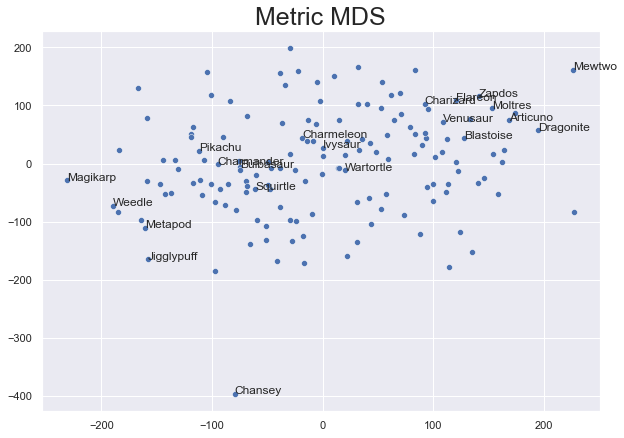

In [50]:
# Calculate MDS based on eucilidian distances
mds = MDS(n_components=2, metric=True, random_state=314159)
euc_transform = mds.fit_transform(df_data[features])

# Calculate MDS based on city block distances
dist_manhattan = manhattan_distances(df_data[features])
mds = MDS(n_components=2, dissimilarity="precomputed",
          metric=True, random_state=314159)
man_transform = mds.fit_transform(dist_manhattan)

# Plot results
ax = sns.scatterplot(x=man_transform[:,0], y=man_transform[:,1])
ax.axes.set_title("Metric MDS",fontsize=25)
iterate = np.array([11,13,39,25,113,129,136,144,145,146,149,150]) - 1
iterate = np.append(iterate, [i for i in range(9)])
for i in iterate:
    ax.text(man_transform[i,0], man_transform[i,1], df_data["Name"].iloc[i])

### 4] Selección del número de dimensiones como proyección objetivo
    - Al correr MDS, scikitlearn regresa una medida de "stress", la cuál indica el cuadrado de las diferencias entre las distancias reales de los datos (en p-dimesiones), comparada con las distancias en las distancias obtenidas al correr el modelo (en k-dimensiones).
    
    - En el caso en que se k=p las distancias se preservarían a la perfección, pero no habría ganancia en términos de reducción de dimensionalidad. Es por eso que, al igual que en PCA, se debe elegir cuántas dimensiones son en las que se proyectará el set original.

Text(0.5, 1.0, 'Elbow test to select projected dimensions')

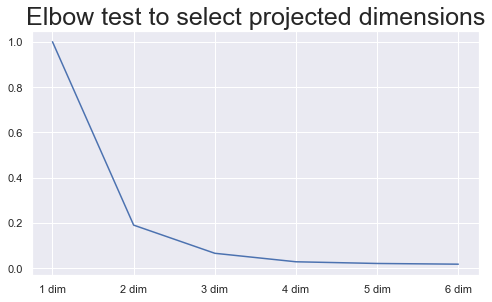

In [77]:
stress = np.array([])
for i in range(6):
    # Calculate MDS based on city block distances
    dist_manhattan = manhattan_distances(df_data[features])
    mds = MDS(n_components=i+1, dissimilarity="precomputed",
              metric=True, random_state=314159)
    man_transform = mds.fit_transform(dist_manhattan)
    stress = np.append(stress,[mds.stress_],0)

# Normalize by max value
stress = stress/stress[0]

# Plot results
sns.set(rc={'figure.figsize':(8,4.5)}) 
ax = sns.lineplot(x=[str(i+1)+" dim" for i in range(6)], y=stress)
ax.axes.set_title("Elbow test to select projected dimensions",fontsize=25)

### 5] Comparación con PCA

    - La principal similitud entre PCA y MDS yace en preservar distancias o relaciones en un espacio menor dimensionalmente.
    
    - PCA puede verse como un caso especial de MDS cuando la medida de disimilitud usada son las distancias euclidianes y los datos originales están centrados. PCA busca encontrar los ejes ortogonales que maximicen la varianza, lo cuál es equivalente a minimizar la distancia euclidiana entre los puntos de datos y el espacio reducido.
    
    - Es importante recordad que PCA y MDS sirven para propósitos distintos. PCA es principalmente usado para reducir variables y maximizar varianza; mientras que MDS se enfoca en conservar la similitud y visualizar la información. Escoger entre estos dos objetivos depende de los objetivos específicos de los datos.

Explained variance:
 [0.397 0.216 0.164 0.113 0.057 0.053]


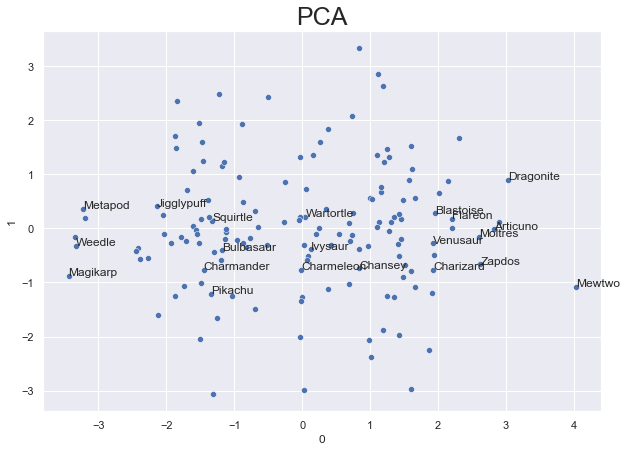

In [52]:
# Transform data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df_data[features])
trans_data = scaler.transform(df_data[features])

# Run PCA model and get PC projections
from sklearn.decomposition import PCA
pca_model = PCA()
pca_model.fit(trans_data)

# Calculate eigenvalues and vectors
pca_data = pca_model.transform(trans_data)
scores = pd.DataFrame(pca_data)

# Explained variance
print("="*100)
print("Explained variance:\n",np.round(pca_model.explained_variance_ratio_,3))
print("="*100)

# Plot results
ax = sns.scatterplot(x=scores[0], y=scores[1])
ax.axes.set_title("PCA",fontsize=25)
for i in iterate:
    ax.text(scores.iloc[i,0], scores.iloc[i,1], df_data["Name"].iloc[i])

### 6] Escalamiento multidimensional no métrico (NMDS)

    - Considera el orden relativo de los puntos de datos en vez de las distancias exactas (métricas). Por ejemplo, que A se parece más a B que a C, pero no toma en cuenta las distancias exactas.
    
    - Esta técnica está diseñada para manejar datos cuyas disimilitudes dos-a-dos están dadas en una escala ordinal o de ranking, en vez de una verdadera medida de escala métrica. Esto la hace adecuada para situaciones donde se tiene información cualitativa, o cuando quiere enfocarse en preservar el order de ranking y sus relaciones entre dos elementos.
    
    - Funciona a través de minimizar una función de estrés, la cual cuantifica las discrepancias entre el orden de ranking en los datos originales y los sugeridos en el espacio reducido. Iterativamente lleva al óptimo.
    
    - El resultado de NMDS es un usualmente un scatterplot in el espacio reducido, donde las distancias entre puntos no son significativas en términos de la escala original, sino que reflejan precisamente las relaciones ordinales. Esta configuración ayuda a visualizar la estructura de los datos
    
    - NMDS es particularmente útil cuando se tienen datos que no pueden ser medidos con precisión en una escala métrica, tales como rankings de preferencia, similaridad de juicios o percepciones subjetivas. Es una herramienta valiosa para visualizar y explorar la estructura subyacente de los datos para revelar patrones que podrían ser no aparentes a simple vista desde la matriz de disimilaridades original.

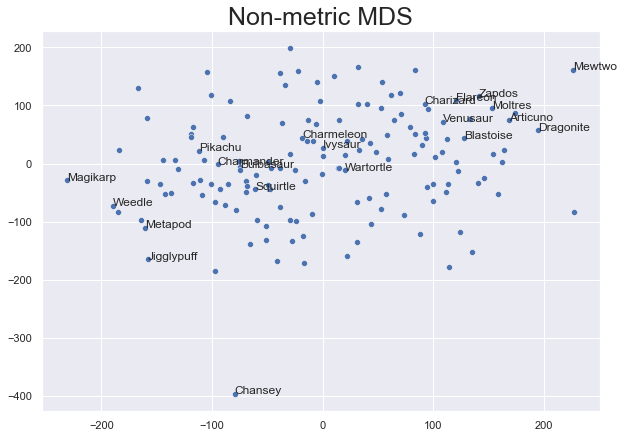

In [80]:
# Calculate NMDS based on city block distances
dist_manhattan = manhattan_distances(df_data[features])
mds = MDS(n_components=2, dissimilarity="precomputed",
          metric=True, random_state=314159)
man_transform = mds.fit_transform(dist_manhattan)

# Plot results
sns.set(rc={'figure.figsize':(10,7)})
ax = sns.scatterplot(x=man_transform[:,0], y=man_transform[:,1])
ax.axes.set_title("Non-metric MDS",fontsize=25)
iterate = np.array([11,13,39,25,113,129,136,144,145,146,149,150]) - 1
iterate = np.append(iterate, [i for i in range(9)])
for i in iterate:
    ax.text(man_transform[i,0], man_transform[i,1], df_data["Name"].iloc[i])